# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en pyhton


In [2]:
import scipy.io as sio
import hdf5storage
# datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
npzfile = np.load('../conjuntos_datos_reconstruidos/fil1_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
npzfile.files

conjunto_datos1= npzfile['arr_1']
npzfile = np.load('../conjuntos_datos_reconstruidos/fil2_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
npzfile.files

conjunto_datos2= npzfile['arr_1']

conjunto_datos=np.concatenate((conjunto_datos1,conjunto_datos2), axis=0)
print(conjunto_datos.shape)

(22703, 3518)


## Network parameters:

In [3]:
batch_size = 500
nb_classes = 10
nb_epoch = 150

# input image dimensions
img_rows, img_cols = 16, 30
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (4, 4)

## Prepare data into training and test set.

22703
conjunto_datos shape: (22703, 3518)
194.99941139023045


/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


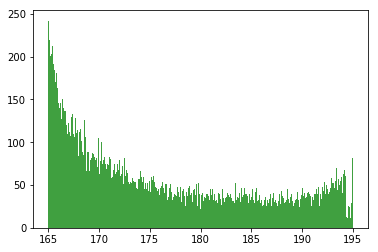

In [4]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# conjunto_datos=photodefbox2_todo_e
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)
maxInColumns = np.amax(conjunto_datos, axis=0)
print (maxInColumns[1])
n, bins, patches = plt.hist(conjunto_datos[:,1], 400, normed=0, facecolor='green', alpha=0.75)


In [5]:
tr_size=60
val_size=20
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)
XY_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]
XY_test_bin0=XY_test[np.where((XY_test[:,1]>=164.9999) * (XY_test[:,1]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,1]>=171.000) * (XY_test[:,1]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,1]>=177.000) * (XY_test[:,1]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,1]>=183.000) * (XY_test[:,1]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,1]>=189.0000))]

X_train=conjunto_datos[:tamanyo_tr,6:3506]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,6:3506]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,6:3506]

X_test_bin0=XY_test_bin0[:,6:3506]
Y_test_bin0=XY_test_bin0[:,1]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,6:3506]
Y_test_bin1=XY_test_bin1[:,1]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,6:3506]
Y_test_bin2=XY_test_bin2[:,1]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,6:3506]
Y_test_bin3=XY_test_bin3[:,1]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,6:3506]
Y_test_bin4=XY_test_bin4[:,1]
print(X_test_bin4.shape)



Y_train=conjunto_datos[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

13621
4540
4542
(1896, 3500)
(851, 3500)
(586, 3500)
(585, 3500)
(624, 3500)


In [6]:
img_cols=175
img_rows=20

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows,1)
X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], img_cols, img_rows,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], img_cols, img_rows,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], img_cols, img_rows,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], img_cols, img_rows,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], img_cols, img_rows,1)

input_shape = (img_cols, img_rows,1)
#input_shape=input_shape.astype('int32')

In [7]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (13621, 175, 20, 1)
13621 train samples
4540 validation samples
4542 test samples


Display 20 random training images using image

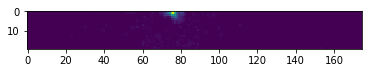

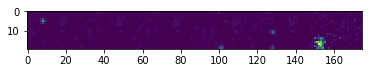

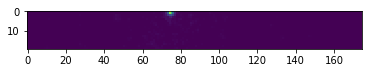

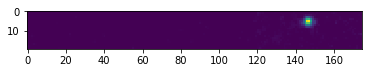

In [8]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_cols]), cmap='viridis')
    plt.show()

## Build the CNN. 

In [9]:
model = Sequential()

model.add(Conv2D(8, kernel_size=kernel_size,
                        padding='same',
                        input_shape=(img_cols,img_rows,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))


model.compile(loss='mean_squared_error',
              optimizer='rmsPROP',
              metrics=['mae','acc'])


Show a summary of the model parameters. 

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 175, 20, 8)        136       
_________________________________________________________________
batch_normalization_1 (Batch (None, 175, 20, 8)        32        
_________________________________________________________________
activation_1 (Activation)    (None, 175, 20, 8)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 87, 10, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 10, 16)        2064      
_________________________________________________________________
batch_normalization_2 (Batch (None, 87, 10, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 87, 10, 16)        0         
__________

And now train the model and evaluate on the test set. 

In [11]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val))

Train on 13621 samples, validate on 4540 samples
Epoch 1/150
13621/13621 [==============================] - 6s 426us/step - loss: 6149.0614 - mean_absolute_error: 54.4957 - acc: 0.0000e+00 - val_loss: 879.9078 - val_mean_absolute_error: 28.6748 - val_acc: 0.0000e+00
Epoch 2/150
13621/13621 [==============================] - 3s 239us/step - loss: 40.2119 - mean_absolute_error: 4.6581 - acc: 0.0000e+00 - val_loss: 994.0560 - val_mean_absolute_error: 30.9800 - val_acc: 0.0000e+00
Epoch 3/150
13621/13621 [==============================] - 3s 251us/step - loss: 50.7445 - mean_absolute_error: 5.6020 - acc: 0.0000e+00 - val_loss: 28.1311 - val_mean_absolute_error: 4.1642 - val_acc: 0.0000e+00
Epoch 4/150
13621/13621 [==============================] - 3s 229us/step - loss: 30.8553 - mean_absolute_error: 4.4107 - acc: 0.0000e+00 - val_loss: 29.7640 - val_mean_absolute_error: 4.4070 - val_acc: 0.0000e+00
Epoch 5/150
13621/13621 [==============================] - 3s 237us/step - loss: 35.5666 - m

Epoch 39/150
13621/13621 [==============================] - 3s 230us/step - loss: 21.2512 - mean_absolute_error: 3.7636 - acc: 0.0000e+00 - val_loss: 37.4899 - val_mean_absolute_error: 5.7699 - val_acc: 0.0000e+00
Epoch 40/150
13621/13621 [==============================] - 3s 247us/step - loss: 18.5936 - mean_absolute_error: 3.4114 - acc: 0.0000e+00 - val_loss: 57.7678 - val_mean_absolute_error: 7.2502 - val_acc: 0.0000e+00
Epoch 41/150
13621/13621 [==============================] - 3s 230us/step - loss: 18.4084 - mean_absolute_error: 3.5851 - acc: 0.0000e+00 - val_loss: 8.5475 - val_mean_absolute_error: 2.3594 - val_acc: 0.0000e+00
Epoch 42/150
13621/13621 [==============================] - 3s 236us/step - loss: 20.1283 - mean_absolute_error: 3.7390 - acc: 0.0000e+00 - val_loss: 28.0375 - val_mean_absolute_error: 4.9279 - val_acc: 0.0000e+00
Epoch 43/150
13621/13621 [==============================] - 3s 226us/step - loss: 18.2021 - mean_absolute_error: 3.5054 - acc: 0.0000e+00 - val_l

13621/13621 [==============================] - 3s 236us/step - loss: 15.5893 - mean_absolute_error: 3.2410 - acc: 0.0000e+00 - val_loss: 4.7199 - val_mean_absolute_error: 1.5229 - val_acc: 0.0000e+00
Epoch 78/150
13621/13621 [==============================] - 3s 242us/step - loss: 18.0710 - mean_absolute_error: 3.2918 - acc: 0.0000e+00 - val_loss: 5.6199 - val_mean_absolute_error: 1.7936 - val_acc: 0.0000e+00
Epoch 79/150
13621/13621 [==============================] - 3s 245us/step - loss: 14.8676 - mean_absolute_error: 3.0681 - acc: 0.0000e+00 - val_loss: 53.6203 - val_mean_absolute_error: 6.8353 - val_acc: 0.0000e+00
Epoch 80/150
13621/13621 [==============================] - 3s 244us/step - loss: 18.0648 - mean_absolute_error: 3.4194 - acc: 0.0000e+00 - val_loss: 18.6403 - val_mean_absolute_error: 3.9364 - val_acc: 0.0000e+00
Epoch 81/150
13621/13621 [==============================] - 3s 232us/step - loss: 16.3813 - mean_absolute_error: 3.3712 - acc: 0.0000e+00 - val_loss: 4.6487 - 

13621/13621 [==============================] - 3s 222us/step - loss: 14.7601 - mean_absolute_error: 3.2181 - acc: 0.0000e+00 - val_loss: 117.3068 - val_mean_absolute_error: 10.6167 - val_acc: 0.0000e+00
Epoch 116/150
13621/13621 [==============================] - 3s 248us/step - loss: 14.4943 - mean_absolute_error: 3.0905 - acc: 0.0000e+00 - val_loss: 14.2972 - val_mean_absolute_error: 3.2853 - val_acc: 0.0000e+00
Epoch 117/150
13621/13621 [==============================] - 3s 230us/step - loss: 16.6544 - mean_absolute_error: 3.4083 - acc: 0.0000e+00 - val_loss: 16.2208 - val_mean_absolute_error: 3.6446 - val_acc: 0.0000e+00
Epoch 118/150
13621/13621 [==============================] - 3s 228us/step - loss: 13.9412 - mean_absolute_error: 2.9258 - acc: 0.0000e+00 - val_loss: 8.5010 - val_mean_absolute_error: 2.4300 - val_acc: 0.0000e+00
Epoch 119/150
13621/13621 [==============================] - 3s 253us/step - loss: 14.3734 - mean_absolute_error: 3.0777 - acc: 0.0000e+00 - val_loss: 43

In [12]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score[0])
print('Test mae:', score[1])
Y_test_predicted=model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

Test mse: 23.997536278358908
Test mae: 4.499439168532795
[195.57137 171.2778  188.43283 170.7439  188.95537 196.9566  174.18861
 192.13669 195.82158 198.66508]
[189.61838646 168.72199634 180.99847038 168.69528274 186.26602127
 190.87447955 170.73269039 187.83115017 193.39890731 192.06887669]
[-5.95297889 -2.55580517 -7.43436043 -2.04861375 -2.68934677 -6.08212446
 -3.4559235  -4.30553806 -2.42267167 -6.59620815]


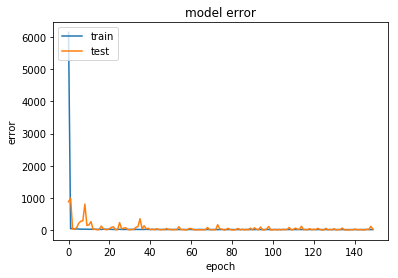

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
#print(error_prediction)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


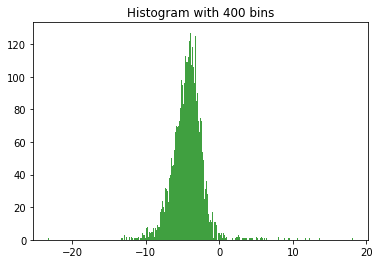

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 400
    # variables        = 3
    chi-square         = 8234.40228
    reduced chi-square = 20.7415675
    Akaike info crit   = 1215.84460
    Bayesian info crit = 1227.81900
[[Variables]]
    amp:  111.278170 +/- 1.06000189 (0.95%) (init = 1000)
    cen: -4.26484024 +/- 0.01777149 (0.42%) (init = 0)
    wid:  2.28496622 +/- 0.02513268 (1.10%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



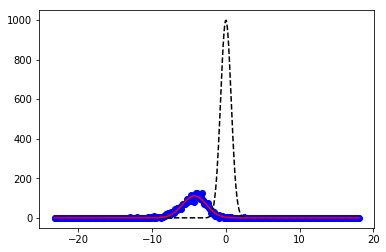

In [15]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [16]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [17]:
print(FWHM)

3.8047183185646527


[[171.2778 ]
 [170.7439 ]
 [174.18861]
 ...
 [170.23424]
 [174.71996]
 [173.10283]]


/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.18766920342576926


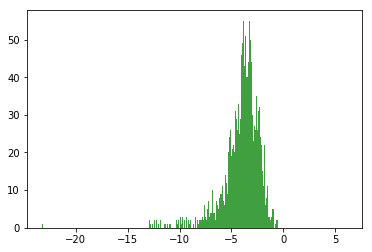

In [18]:
Y_test_bin0_predicted=model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.22114085351833007


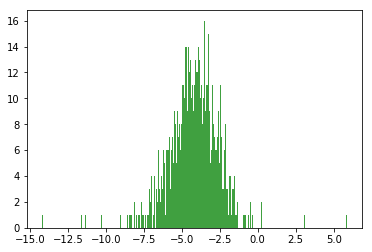

In [19]:
Y_test_bin1_predicted=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


3.2108909953295677


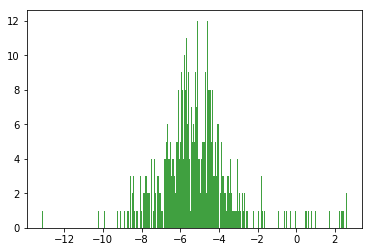

In [20]:
Y_test_bin2_predicted=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


3.5662651124300435


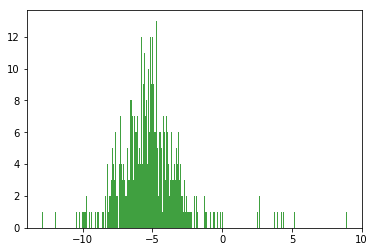

In [21]:
Y_test_bin3_predicted=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


4.852060242359658
3.5662651124300435
3.2108909953295677
0.22114085351833007
0.18766920342576926


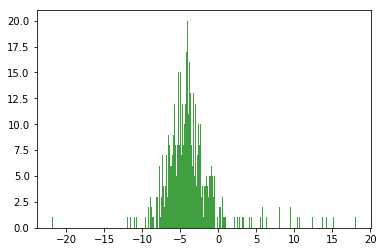

In [22]:
Y_test_bin4_predicted=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)